<a href="https://colab.research.google.com/github/emukans/minGPT-translator/blob/master/with_valid_Proper_packages_minGPT_EN_LV_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!nvidia-smi

Fri Jul 23 11:22:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

import os
import urllib
import re
import random
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import pickle
from torch.nn import functional as F

from collections import OrderedDict, Counter

%matplotlib inline

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(1)

In [ ]:
!pip install sacrebleu

     |████████████████████████████████| 54 kB 2.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Text preprocessing

In [ ]:
# Read Hemingway texts from URL. There are Hemingway's "A Farewell to arms"
text_input = urllib.request.urlopen('http://www.ltn.lv/~guntis/translation_dataset/dataset_en_small.txt').read().decode("utf-8", "ignore")
text_output = urllib.request.urlopen('http://www.ltn.lv/~guntis/translation_dataset/dataset_lv_small.txt').read().decode("utf-8-sig", "ignore")

# text_input = ''.join(open('/content/drive/MyDrive/tilde en-lv data/train.lv').readlines()[:10000])
# text_output = ''.join(open('/content/drive/MyDrive/tilde en-lv data/train.en').readlines()[:10000])

with open('en.txt', 'w') as f:
    f.write(text_input)

with open('lv.txt', 'w') as f:
    f.write(text_output)

In [ ]:
!git clone https://github.com/moses-smt/mosesdecoder.git

Cloning into 'mosesdecoder'...
remote: Enumerating objects: 148070, done.
remote: Counting objects: 100% (498/498), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 148070 (delta 315), reused 433 (delta 289), pack-reused 147572
Receiving objects: 100% (148070/148070), 129.86 MiB | 23.03 MiB/s, done.
Resolving deltas: 100% (114341/114341), done.


In [ ]:
# Normalize and tokenize texts

!cat en.txt | mosesdecoder/scripts/tokenizer/normalize-punctuation.perl -l en \
  | mosesdecoder/scripts/tokenizer/tokenizer.perl -a -l en > en.tok.txt

!cat lv.txt | mosesdecoder/scripts/tokenizer/normalize-punctuation.perl -l lv \
  | mosesdecoder/scripts/tokenizer/tokenizer.perl -a -l lv > lv.tok.txt

Tokenizer Version 1.1
Language: en
Number of threads: 1
Tokenizer Version 1.1
Language: lv
Number of threads: 1


In [ ]:
!mosesdecoder/scripts/recaser/train-truecaser.perl -corpus en.tok.txt -model tc.en
!mosesdecoder/scripts/recaser/train-truecaser.perl -corpus lv.tok.txt -model tc.lv

!mosesdecoder/scripts/recaser/truecase.perl -model tc.en < en.tok.txt > en.tc.txt
!mosesdecoder/scripts/recaser/truecase.perl -model tc.lv < lv.tok.txt > lv.tc.txt

In [ ]:
!pip install subword-nmt

In [ ]:
!subword-nmt learn-joint-bpe-and-vocab --input en.tc.txt lv.tc.txt -s 2000 -o tokens.lven --write-vocabulary token_freq.en.txt token_freq.lv.txt
# !subword-nmt learn-joint-bpe-and-vocab --input en.tc.txt -s 5000 -o tokens.en.txt --write-vocabulary token_freq.en.txt
# !subword-nmt learn-joint-bpe-and-vocab --input lv.tc.txt -s 5000 -o tokens.lv.txt --write-vocabulary token_freq.lv.txt

In [ ]:
vocab_size = 4500

def build_vocab(freq_file, vocab_size):
    vocab = Counter(['<pad>', '<eos>', '<sep>', '<unk>'])
    with open(freq_file, 'r') as f:
        for line in f.readlines():
            token, num_occurs = line.split()
            vocab[token] += int(num_occurs)

    return vocab

en_vocab = build_vocab('token_freq.en.txt', vocab_size)
lv_vocab = build_vocab('token_freq.lv.txt', vocab_size)

en_vocab = build_vocab('token_freq.en.txt', vocab_size)
lv_vocab = build_vocab('token_freq.lv.txt', vocab_size)


joint_vocab = Counter(en_vocab)
joint_vocab.update(lv_vocab)

# with open('vocab.en.txt', 'w') as f:
#     for i, token in enumerate(en_vocab):
#         f.write(f"{token} {i + 1} \n")

# with open('vocab.lv.txt', 'w') as f:
#     for i, token in enumerate(lv_vocab):
#         f.write(f"{token} {i + 1} \n")

with open('vocab.lven', 'w') as f:
    for i, token in enumerate(joint_vocab):
        f.write(f"{token} {joint_vocab[token]} \n")

In [ ]:
!subword-nmt apply-bpe -c tokens.lven --vocabulary vocab.lven --vocabulary-threshold 1 < en.tc.txt > en.BPE.txt
!subword-nmt apply-bpe -c tokens.lven --vocabulary vocab.lven --vocabulary-threshold 1 < lv.tc.txt > lv.BPE.txt

In [ ]:
with open('lv.BPE.txt', 'r') as f:
    text_input = f.read()

with open('en.BPE.txt', 'r') as f:
    text_output = f.read()

#MinGPT

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

def calculate_attention_token(attention, top_k, model):
    logits = model.head(attention)
    logits = logits[:, -1, :]
    logits = top_k_logits(logits, top_k)

    probs = F.softmax(logits)

    _, ix = torch.topk(probs, k=1, dim=-1)
    ix = torch.multinomial(probs, num_samples=top_k)

    return ix[0]


@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None, output_attention=False):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    attention_state = [[] for _ in model.blocks]

    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)

        if output_attention:
            b, t = x.size()

            for block_id in range(len(model.blocks)):
                att = model.blocks[block_id].attn.att
                attention_state[block_id].append(att)

        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    if output_attention:
        return x, attention_state

    return x


In [ ]:
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.att = None

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))

        self.att = att

        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0)

        return logits, loss


In [ ]:
%matplotlib inline

def plot_loss(train_loss_list, test_loss_list, valid_loss_list, valid_bleu_list):
    epochs = range(len(test_loss_list))
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(30, 20))
    axs[0].plot(epochs, train_loss_list)
    axs[0].set_title('Train loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    axs[1].plot(epochs, test_loss_list)
    axs[1].set_title('Test loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')

    axs[2].plot(epochs, valid_loss_list)
    axs[2].set_title('Validation loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')

    axs[3].plot(epochs, valid_bleu_list)
    axs[3].set_title('Validation BLEU')
    axs[3].set_xlabel('Epochs')
    axs[3].set_ylabel('BLEU')

    plt.show()

In [ ]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import sacrebleu
import math
import logging
from random import choice

from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

logger = logging.getLogger(__name__)

def clean_tokens(sentence):
    return sentence.replace('@@ ', '').replace(' @', '').replace('@ ', '')

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, valid_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.valid_dataset = valid_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self, postfix=''):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        checkpoint_path = self.config.ckpt_path + postfix + '.pt'
        logger.info("saving %s", checkpoint_path)
        torch.save(raw_model.state_dict(), checkpoint_path)

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset
            if split == 'test':
                data = self.test_dataset
            elif split == 'valid':
                data = self.valid_dataset
                model.eval()
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=config.batch_size,
                                num_workers=config.num_workers)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            logits_total = None
            x_total = None
            y_total = None
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())
                    if split == 'valid':
                        if logits_total is None:
                            logits_total = logits
                            x_total = x
                            y_total = y
                        else:
                            logits_total = torch.cat((logits_total, logits), dim=0)
                            x_total = torch.cat((x_total, x), dim=0)
                            y_total = torch.cat((y_total, y), dim=0)
                        

                if is_train:
                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        # self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        self.tokens += (y > 0).sum() # number of tokens processed this step (i.e. label is not -100) !!!in our case is not 0
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. mean loss: {float(np.mean(losses)):.5f}. lr {lr:e}")

            if split == 'train':
                train_loss = float(np.mean(losses))
                print(f"train loss: {train_loss}")

                return train_loss

            if split == 'test':
                test_loss = float(np.mean(losses))
                print(f"test loss: {test_loss}")
                return test_loss

            if split == 'valid':
                test_loss = float(np.mean(losses))
                print(f"valid loss: {test_loss}")

                eval_results = []
                translation_results = []
                context_list = []

                for idx in range(len(logits_total)):
                    intent = (x_total[idx] == valid_dataset.tokenizer_input.encode(['<sep>'])[0]).nonzero(as_tuple=True)[0][0]

                    probs = F.softmax(logits_total[idx], dim=-1)
                    # sample from the distribution or take the most likely
                    _, predicted = torch.topk(probs, k=1, dim=-1)
                    context = clean_tokens(data.tokenizer_input.decode(x_total[idx][:intent - 1], True))
                    completion = clean_tokens(data.tokenizer_output.decode(predicted[intent:], True))
                    real = clean_tokens(data.tokenizer_output.decode(y_total[idx][intent:], True))

                    context_list.append(context)
                    translation_results.append(completion)
                    eval_results.append(real)
                
                with open('valid.txt', 'w') as f:
                    f.write("\n".join(translation_results))

                with open('eval.txt', 'w') as f:
                    f.write("\n".join(eval_results))

                with open('context.txt', 'w') as f:
                    f.write("\n".join(context_list))


                !cat valid.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > valid.detok.txt
                !cat eval.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > eval.detok.txt
                !cat context.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > context.detok.txt

                with open('eval.detok.txt', 'r') as f:
                    eval_results = [l.strip() for l in f.readlines()]
                with open('valid.detok.txt', 'r') as f:
                    translation_results = [l.strip() for l in f.readlines()]
                with open('context.detok.txt', 'r') as f:
                    context_list = [l.strip() for l in f.readlines()]

                valid_sentences = ['the driver wore a cap and his face was thin and very tanned.',
                                   'outside it was getting dark.',
                                   'the two girls were asleep.',
                                   'I would like to have had the uniform off although I did not care much about the outward forms.',
                                   'I watched the flashes on San Gabriele.',
                                   'I asked.',
                                   '"no.']

                idx_list = [i for i, sentence in enumerate(eval_results) if sentence in valid_sentences]

                for idx in idx_list:
                    print(f'Input:            {context_list[idx]}')
                    print(f'Predicted output: {translation_results[idx]}')
                    print(f'Real output:      {eval_results[idx]}')
                    print('--------------------------------------------------')

                refs = [eval_results]
                sys = translation_results
                bleu = sacrebleu.corpus_bleu(sys, refs)
                print(f'BLEU: {bleu.score}')
                print('##############################################################')

                return test_loss, bleu.score

        train_loss_list = []
        test_loss_list = []
        valid_loss_list = []
        valid_bleu_list = []
        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            train_loss = run_epoch('train')
            train_loss_list.append(train_loss)
            if self.test_dataset is not None:
                test_loss = run_epoch('test')
                test_loss_list.append(test_loss)

            if self.valid_dataset is not None:
                valid_loss, bleu_score = run_epoch('valid')
                valid_loss_list.append(valid_loss)
                valid_bleu_list.append(bleu_score)

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint("_best")

            if epoch % 10 == 0:
                self.save_checkpoint(f"_{epoch}")
                # plot_loss(train_loss_list, test_loss_list, valid_loss_list, valid_bleu_list)

            self.save_checkpoint("_last")

        return train_loss_list, test_loss_list, valid_loss_list, valid_bleu_list


#Training

In [ ]:

class Tokenizer:
    def __init__(self, data, vocab_size, vocab):
        self.vocab_size = vocab_size
        self.vocab = vocab

        self.stoi = {ch: i for i, ch in enumerate(self.vocab)}
        self.itos = {i: ch for i, ch in enumerate(self.vocab)}
    
    def tokenize(self, data, block_size):
        tokenized_text = data.split()
        # Filter empty strings
        tokenized_text = [x for x in tokenized_text if x]
        result = []
        for tokenized in tokenized_text:
            # In case other single # found, replace them with <unk> special token, marking the element as unknown
            if tokenized in self.vocab:
                result.append(tokenized)
            else:
                result.append('<unk>')

        # in case the sentence is longer, than block_size, we trim the sentence
        return result[:block_size]
    
    def encode(self, data):
        return [self.stoi[s] for s in data]
    
    def decode(self, data, clean_paddings=False):
        token_list = [self.itos[int(i)] for i in data]
        text = ' '.join(token_list)

        if not clean_paddings:
            return text

        eos_index = (data == self.encode(['<eos>'])[0]).nonzero(as_tuple=True)[0]
        if len(eos_index):
            eos_index = eos_index[0]
            text = ' '.join(token_list[:eos_index])

        return text.replace('<pad>', '').replace('  ', '')

In [ ]:
len(list(joint_vocab))

2120

In [ ]:
# vocab_size = 10000

# vocab_input = None
# if os.path.exists('vocab_input.pkl'):
#     with open('vocab_input.pkl', 'rb') as f:
#         vocab_input = pickle.load(f)
        
# vocab_output = None
# if os.path.exists('vocab_output.pkl'):
#     with open('vocab_output.pkl', 'rb') as f:
#         vocab_output = pickle.load(f)

# building vocabluary can take some time. ~5 minutes for 10_000 tokens for each tokenizer. 
tokenizer_input = Tokenizer(text_input, len(joint_vocab), list(joint_vocab))
tokenizer_output = Tokenizer(text_output, len(joint_vocab), list(joint_vocab))

In [ ]:
# with open('vocab_input.pkl', 'wb') as f:
#     pickle.dump(tokenizer_input.vocab, f)

# with open('vocab_output.pkl', 'wb') as f:
#     pickle.dump(tokenizer_output.vocab, f)

In [ ]:
# Shuffle texts by lines
texts = list(zip(text_output.splitlines(), text_input.splitlines()))
random.shuffle(texts)

text_output, text_input = zip(*texts)

In [ ]:
# Split texts into train, test and validation datasets
train_dataset_size = round(0.75 * len(text_output))
test_dataset_size = round(0.15 * len(text_output))
valid_dataset_size = round(0.1 * len(text_output))

train_input = text_input[:train_dataset_size]
test_input = text_input[train_dataset_size:train_dataset_size + test_dataset_size]
valid_input = text_input[-valid_dataset_size:]

train_output = text_output[:train_dataset_size]
test_output = text_output[train_dataset_size:train_dataset_size + test_dataset_size]
valid_output = text_output[-valid_dataset_size:]


In [ ]:
from torch.utils.data import Dataset

class WordDataset(Dataset):

    def __init__(self, output_text, input_text, tokenizer_output, tokenizer_input, block_size):
        self.tokenizer_output = tokenizer_output
        self.tokenizer_input = tokenizer_input

        self.block_size = block_size * 2 + 2
        self.output_text = [tokenizer_output.tokenize(t, block_size) for t in output_text]
        self.input_text = [tokenizer_input.tokenize(t, block_size) for t in input_text]

    def __len__(self):
        return len(self.output_text)

    def __getitem__(self, idx):
        """
        The idea is to get the input sentence
        and translate it to output sentence (sentences could be on any language).

        In the init method we already split a sentence into tokens and filled with spaces,
        to have an equal sentence size. In this method we just encode the tokens to
        ids (a list of numbers), and we're trying to map ids sequences
        """

        tokenized_input_text = self.tokenizer_input.encode(self.input_text[idx])
        tokenized_output_text = self.tokenizer_output.encode(self.output_text[idx])

        dix = tokenized_input_text + self.tokenizer_output.encode(['<sep>']) + tokenized_output_text + self.tokenizer_output.encode(['<eos>'])
        if len(dix) < self.block_size:
            dix += self.tokenizer_output.encode(['<pad>']) * (self.block_size - len(dix))

        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        x[len(tokenized_input_text) + len(tokenized_output_text):] = self.tokenizer_output.encode(['<pad>'])[0]
        y[:len(tokenized_input_text)] = self.tokenizer_output.encode(['<pad>'])[0]

        return x, y

In [ ]:
block_size = 100  # the estimate how long lines the text could be (token count)

train_dataset = WordDataset(train_output, train_input, tokenizer_output, tokenizer_input, block_size)
test_dataset = WordDataset(test_output, test_input, tokenizer_output, tokenizer_input, block_size)
valid_dataset = WordDataset(valid_output, valid_input, tokenizer_output, tokenizer_input, block_size)

In [ ]:
tokenizer_input.decode(valid_dataset[0][0], True)

'ie@@ dz@@ er , mazais ! <sep> drink that , baby'

In [ ]:
# number_of_heads = 8
# number_of_layers = 6
number_of_heads = 4
number_of_layers = 2

# from mingpt.model import GPT, GPTConfig
embd_pdrop = 0.1
resid_pdrop = 0.1
attn_pdrop = 0.1

max_vocab = max(tokenizer_input.vocab_size, tokenizer_output.vocab_size)

mconf = GPTConfig(max_vocab, train_dataset.block_size,
                  n_layer=number_of_layers, n_head=number_of_heads, n_embd=512,
                  embd_pdrop=embd_pdrop, resid_pdrop=resid_pdrop, attn_pdrop=attn_pdrop)
model = GPT(mconf)

In [ ]:
tokenizer_input.vocab_size

2120

In [ ]:
# from mingpt.trainer import Trainer, TrainerConfig

tokens_per_epoch = len(train_dataset) * block_size
train_epochs = 100

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=64, learning_rate=3e-5,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='drive/MyDrive/minGPT LV-EN/translator_model',
                      num_workers=1, weight_decay=0.01, betas=(0.9, 0.95))
trainer = Trainer(model, train_dataset, test_dataset, valid_dataset, tconf)

In [ ]:
param_count = sum([param.nelement() for param in model.parameters()])

print(f'Parameters count: {param_count}')

Parameters count: 8580096


In [ ]:
train_loss_list, test_loss_list, valid_loss_list, valid_bleu_list = trainer.train()

epoch 1 iter 103: train loss 7.00072. mean loss: 7.40255. lr 4.599365e-06: 100%|██████████| 104/104 [00:18<00:00,  5.51it/s]

train loss: 7.40255499803103


test loss: 6.872650328136626
valid loss: 6.856130429676601
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "" ""
Real output:      "no.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: "
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: 
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: "" "
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju


epoch 2 iter 103: train loss 6.15039. mean loss: 6.51117. lr 9.198729e-06: 100%|██████████| 104/104 [00:19<00:00,  5.44it/s]

train loss: 6.511165297948397


test loss: 6.001115889776321
valid loss: 6.0039123467036655
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the the the the the the the the the the the the the the the the the the the
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: ..........................
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: ...
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas

epoch 3 iter 103: train loss 5.72872. mean loss: 5.80993. lr 1.379809e-05: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]

train loss: 5.809932020994333


test loss: 5.4905648458571665
valid loss: 5.488188164574759
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I..
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: ...
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: I.......
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            "nē
Predicted output: "..
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I.........................
Real output:      I would like to have had the uniform off although I did not care much about the outward for

epoch 4 iter 103: train loss 5.10307. mean loss: 5.35491. lr 1.839746e-05: 100%|██████████| 104/104 [00:20<00:00,  5.15it/s]

train loss: 5.354909589657416


test loss: 5.120017732892718
valid loss: 5.127983467919486
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I..
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I..
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: I.......
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I..
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: I the.....
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            vaicāju
Predicted output: I..
Real output:      I as

epoch 5 iter 103: train loss 4.26288. mean loss: 5.03005. lr 2.299682e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 5.030053079128265


test loss: 4.844916797819591
valid loss: 4.862390995025635
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I was I I the the....... said............
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I..
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I..
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I..
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
----------------------

epoch 6 iter 103: train loss 4.68141. mean loss: 4.78038. lr 2.759619e-05: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]

train loss: 4.780377310055953


test loss: 4.638847555433001
valid loss: 4.663353817803519
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the was the road the the the. the......
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I was.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I was.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the was and and and was and and the and and and and the the and. and.
R

epoch 7 iter 103: train loss 4.39264. mean loss: 4.56369. lr 2.999996e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 4.5636938856198235


test loss: 4.438473201933361
valid loss: 4.473537615367344
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I was a the the a a road..... was not. a... road.....
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I 'm.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: the the was a...
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            vaicāju
Predicted output: 

epoch 8 iter 103: train loss 4.65332. mean loss: 4.36395. lr 2.999961e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 4.36395356288323


test loss: 4.27251995177496
valid loss: 4.307940551212856
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I was a a the a a road not.. ing. was not a es.. it road.....
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I 'm.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I 'm.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un 

epoch 9 iter 103: train loss 4.13508. mean loss: 4.18270. lr 2.999891e-05: 100%|██████████| 104/104 [00:20<00:00,  5.20it/s]

train loss: 4.182700959535746


test loss: 4.136127960114252
valid loss: 4.164526700973511
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the was the road es ed es the the con ed ed ed.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            es jautāju
Predicted output: I 'm.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I 'm.
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: i

epoch 10 iter 103: train loss 4.04642. mean loss: 4.03288. lr 2.999785e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 4.032880938970125


test loss: 4.015046562467303
valid loss: 4.062749607222421
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the had the road es ly es the the con on ed on.
Real outpu

epoch 11 iter 103: train loss 3.97709. mean loss: 3.89891. lr 2.999644e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 3.898913514155608


test loss: 3.92553212529137
valid loss: 3.969599025590079
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the had the bes ly es. the con on ed le.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real outpu

epoch 12 iter 103: train loss 3.71021. mean loss: 3.78120. lr 2.999467e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 3.7812038247401896


test loss: 3.834840081986927
valid loss: 3.87334782736642
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the road and ing was little was and the was was a s the the boued and
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had not a be a been ft. to s. had not see es.. it fd d...
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:       

epoch 13 iter 103: train loss 3.71791. mean loss: 3.67758. lr 2.999255e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 3.677578325455005


test loss: 3.7670528434571766
valid loss: 3.805369462285723
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was very on..
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the bwas was a s ing.
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output

epoch 14 iter 103: train loss 3.11300. mean loss: 3.57741. lr 2.999008e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 3.5774138134259443


test loss: 3.7150636854625882
valid loss: 3.744581307683672
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: it had be a be a been fing.. s. had not. u.. it fd d...
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the was wa

epoch 15 iter 103: train loss 3.73038. mean loss: 3.48743. lr 2.998724e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 3.487427395123702


test loss: 3.651618787220546
valid loss: 3.702797991888864
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the road and ing was long p and the face was a s the the boued and
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------

epoch 16 iter 103: train loss 2.97315. mean loss: 3.39985. lr 2.998406e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 3.399854084620109


test loss: 3.579926161538987
valid loss: 3.6359257868358066
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was very on..
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the road and ing was was p and was face was very s and the bouicand
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Rea

epoch 17 iter 103: train loss 3.74872. mean loss: 3.32465. lr 2.998052e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 3.324648352769705


test loss: 3.549319471631731
valid loss: 3.5917534828186035
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the was was were the s an.
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was very on..
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            "nē
Predicted output: "no.


epoch 18 iter 103: train loss 3.20061. mean loss: 3.24253. lr 2.997662e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 3.242528280386558


test loss: 3.5083986691066196
valid loss: 3.5465551614761353
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the sle st es on the con od ole.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was very on..
Real output:      outside it was getting dark.
--------------------------------------------------
Input:        

epoch 19 iter 103: train loss 3.25712. mean loss: 3.17504. lr 2.997237e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 3.1750444105038276


test loss: 3.476568029040382
valid loss: 3.511400478226798
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was very on..
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had be a be a been fm. to s. had not see u.. it fd d. t.
Real output:      I would like to have had the uniform off al

epoch 20 iter 103: train loss 2.51488. mean loss: 3.09789. lr 2.996777e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 3.097889785583203


test loss: 3.429691439583188
valid loss: 3.4781516960689
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            abas meitenes bija iemigušas
Predicted output: the was was were the s w.
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the road was ore was long p and the face was a s and his boukand
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predict

epoch 21 iter 103: train loss 2.95413. mean loss: 3.03184. lr 2.996281e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 3.0318369704943438


test loss: 3.401455561319987
valid loss: 3.45046523639134
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the sle st es on the cSod ole.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:  

epoch 22 iter 103: train loss 3.11944. mean loss: 2.96971. lr 2.995750e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 2.9697070924135356


test loss: 3.3645275093260265
valid loss: 3.4119631562914168
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was very tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
----------------------

epoch 23 iter 103: train loss 3.30067. mean loss: 2.90892. lr 2.995183e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 2.9089183188401737


test loss: 3.3495540505363826
valid loss: 3.382891467639378
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they would be a be a been fm. to s. had not to u.. it fd en. ward.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the road was ore was was p and his face was very s and his much oukand
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the was the sle st es on the cSod ole.
Real output:      I wat

epoch 24 iter 103: train loss 2.73268. mean loss: 2.84434. lr 2.994581e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 2.8443380273305454


test loss: 3.3305392151787165
valid loss: 3.3843102625438144
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the mountains was ore was was p and his face was very s and his much oukand
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was dark tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            vaicāju
Pr

epoch 25 iter 103: train loss 2.70506. mean loss: 2.78855. lr 2.993943e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 2.788546186227065


test loss: 3.309913850965954
valid loss: 3.367042439324515
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            abas meitenes bija iemigušas
Predicted output: the was girls were all s w.
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the mountains was ore was was p and his face was very s and his boukand
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Pre

epoch 26 iter 103: train loss 2.28948. mean loss: 2.72790. lr 2.993271e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 2.7278952919519863


test loss: 3.2770121892293296
valid loss: 3.318486213684082
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they would not a be a been fm. to led. had not to u.. it fd en. ward.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:

epoch 27 iter 103: train loss 2.88416. mean loss: 2.67367. lr 2.992562e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 2.673671786601727


test loss: 3.298453058515276
valid loss: 3.3470704555511475
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:      

epoch 28 iter 103: train loss 2.76626. mean loss: 2.61802. lr 2.991819e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 2.6180194409993978


test loss: 3.2573325861068
valid loss: 3.3052466937473843
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had be a be a a fm of to led. had not to u.. it fd en. ward.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I ask

epoch 29 iter 103: train loss 2.61368. mean loss: 2.56953. lr 2.991040e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 2.5695290794739356


test loss: 3.2538035483587358
valid loss: 3.290728909628732
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was dark tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two g

epoch 30 iter 103: train loss 2.19918. mean loss: 2.50786. lr 2.990226e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 2.5078630470312557


test loss: 3.2240522702534995
valid loss: 3.2818771260125295
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were not s gs.
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had not a be a a fm of to led. had not think u.. it fd en. ward.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
I

epoch 31 iter 103: train loss 2.26386. mean loss: 2.46049. lr 2.989377e-05: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]

train loss: 2.4604917283241567


test loss: 3.2271037782941545
valid loss: 3.2717677695410594
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            metās jau tumsa
Predicted output: it it was dark tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the mountains was ore was was p and his face was very s and his bles kand
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had have a be a a fm of to led. had not to u.. it fd en. ward.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
---------

epoch 32 iter 103: train loss 2.33463. mean loss: 2.40936. lr 2.988492e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 2.4093629947075477


test loss: 3.207280408768427
valid loss: 3.2481340169906616
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the mountains was ore was was p and his face was in s and his boukin
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: t

epoch 33 iter 103: train loss 2.72218. mean loss: 2.36339. lr 2.987572e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 2.3633935703681064


test loss: 3.2253923529670354
valid loss: 3.275585310799735
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was dark tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the was the sle st es on the an Sabole.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the mountains was ore wa

epoch 34 iter 103: train loss 2.55412. mean loss: 2.31572. lr 2.986617e-05: 100%|██████████| 104/104 [00:20<00:00,  5.20it/s]

train loss: 2.315721891247309


test loss: 3.1942635150182817
valid loss: 3.2428471190588817
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I would be a be a a fm of 

epoch 35 iter 103: train loss 2.20063. mean loss: 2.26619. lr 2.985627e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 2.266187221958087


test loss: 3.217563504264468
valid loss: 3.247769440923418
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            metās jau tumsa
Predicted output: it it was dark tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I would have a be a a fm of to s. had not think u.. it fd en. ward.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            

epoch 36 iter 103: train loss 2.31095. mean loss: 2.21978. lr 2.984602e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 2.219781822883166


test loss: 3.1854779039110457
valid loss: 3.237586123602731
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was dark tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the mountains was ore was was p and his face was very s his his bles k.
Real output:      the driver wore a cap and his

epoch 37 iter 103: train loss 2.39065. mean loss: 2.17474. lr 2.983541e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 2.1747398170141072


test loss: 3.1753086362566267
valid loss: 3.219402091843741
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabole.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they would have a have a a fm of to led. would not think u.. it fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
-----------

epoch 38 iter 103: train loss 1.98621. mean loss: 2.12597. lr 2.982445e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 2.125974531357105


test loss: 3.1918375265030634
valid loss: 3.251534717423575
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they would be a be a a fm of to s. had not think u.. them fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were not s gs.
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: the hwas ore was long p and his face was very s and his bles kup
Real output:      the driver wore a cap and his face was thin and very tanned.
-------

epoch 39 iter 103: train loss 2.09647. mean loss: 2.08557. lr 2.981315e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 2.0855730462532778


test loss: 3.167259148189
valid loss: 3.2084029061453685
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were not s gs on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------

epoch 40 iter 103: train loss 2.11024. mean loss: 2.03619. lr 2.980149e-05: 100%|██████████| 104/104 [00:20<00:00,  5.14it/s]

train loss: 2.0361941708968234


test loss: 3.1756545021420433
valid loss: 3.232225775718689
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real out

epoch 41 iter 103: train loss 1.88870. mean loss: 1.98981. lr 2.978948e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 1.9898126388971622


test loss: 3.1831116676330566
valid loss: 3.2360746009009227
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was dark tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
----------------------------------------------

epoch 42 iter 103: train loss 1.93888. mean loss: 1.94846. lr 2.977712e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 1.9484637047235782


test loss: 3.160626797449021
valid loss: 3.2055749552590505
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the was the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kals

epoch 43 iter 103: train loss 2.02271. mean loss: 1.90998. lr 2.976441e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 1.9099751596267407


test loss: 3.171089535667783
valid loss: 3.222338284764971
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they would have a have a a fm of to led. had not think u.. it fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:    

epoch 44 iter 103: train loss 1.64832. mean loss: 1.86495. lr 2.975136e-05: 100%|██████████| 104/104 [00:20<00:00,  5.20it/s]

train loss: 1.8649527373222203


test loss: 3.1828810487474715
valid loss: 3.2330721616744995
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were at s gs on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicte

epoch 45 iter 103: train loss 1.52568. mean loss: 1.82383. lr 2.973795e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 1.823831239571938


test loss: 3.173343817392985
valid loss: 3.2160068409783498
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were cos gs on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was dark tting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            šoferim galvā 

epoch 46 iter 103: train loss 2.09205. mean loss: 1.78354. lr 2.972419e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 1.7835440200108748


test loss: 3.195525498617263
valid loss: 3.236980710710798
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted o

epoch 47 iter 103: train loss 1.61595. mean loss: 1.74317. lr 2.971009e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 1.7431687918993144


test loss: 3.178896869931902
valid loss: 3.2319901500429427
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had have a have a a fm of to s. could not think u.. it fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the was the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegus

epoch 48 iter 103: train loss 1.88960. mean loss: 1.70426. lr 2.969564e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 1.7042581255619342


test loss: 3.186971584955851
valid loss: 3.2367418152945384
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s gs on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driwas ore was and p and his face was hs his his bles kup
Real output:      the driver wore a cap and his f

epoch 49 iter 103: train loss 1.66439. mean loss: 1.66279. lr 2.968084e-05: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]

train loss: 1.6627887785434723


test loss: 3.191093717302595
valid loss: 3.2318689141954695
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had have a have a a sam of to s. could not think ua. it sasen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.


epoch 50 iter 103: train loss 1.70303. mean loss: 1.62547. lr 2.966569e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 1.6254654263074582


test loss: 3.206557024092901
valid loss: 3.25227757862636
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s gs on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:           

epoch 51 iter 103: train loss 1.28740. mean loss: 1.58663. lr 2.965019e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 1.5866284427734523


test loss: 3.204347633180164
valid loss: 3.2615761246000017
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the was the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had have a have a a fm of to s. thought not think ua. it f

epoch 52 iter 103: train loss 1.67520. mean loss: 1.54490. lr 2.963435e-05: 100%|██████████| 104/104 [00:19<00:00,  5.20it/s]

train loss: 1.5448950265462582


test loss: 3.2239914621625627
valid loss: 3.274096574102129
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
----------

epoch 53 iter 103: train loss 1.70307. mean loss: 1.51309. lr 2.961817e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 1.5130871660434282


test loss: 3.243451470420474
valid loss: 3.302521654537746
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
-----------------------------------------------

epoch 54 iter 103: train loss 1.50333. mean loss: 1.47329. lr 2.960163e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 1.4732858080130358


test loss: 3.228529521397182
valid loss: 3.287166850907462
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driwas ore was long p and his face was herhis his bles kup
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            labprāt būtu aizmetis

epoch 55 iter 103: train loss 1.50986. mean loss: 1.43664. lr 2.958475e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 1.436643762084154


test loss: 3.25641884122576
valid loss: 3.3108623708997453
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had never a have a a sam of with s. had not think u.. it fd en. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the could the Ble st es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
---------------------------

epoch 56 iter 103: train loss 1.19923. mean loss: 1.40071. lr 2.956753e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 1.400707476414167


test loss: 3.248510247185117
valid loss: 3.299175330570766
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
---------------------------------------

epoch 57 iter 103: train loss 1.34698. mean loss: 1.36655. lr 2.954996e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 1.3665514141321182


test loss: 3.2576417128245034
valid loss: 3.321623376437596
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārie

epoch 58 iter 103: train loss 1.33634. mean loss: 1.33564. lr 2.953204e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 1.3356421624238675


test loss: 3.2732480821155368
valid loss: 3.312822103500366
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they would have a have a a sam of to s. thought not think u.. it fd en. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no

epoch 59 iter 103: train loss 1.10859. mean loss: 1.29535. lr 2.951379e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 1.2953526675701141


test loss: 3.2656774861471995
valid loss: 3.3183407953807285
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they had have a have a a fm now to s. could not think ua. it fsen. m.
Real output:      I would like to have had the uniform off although I did n

epoch 60 iter 103: train loss 1.24016. mean loss: 1.26435. lr 2.949518e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 1.264345796062396


test loss: 3.2709143388838995
valid loss: 3.324088556425912
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driwas ore was long p and his face was herhis his bles kup
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted ou

epoch 61 iter 103: train loss 1.05202. mean loss: 1.23181. lr 2.947624e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 1.2318093192118864


test loss: 3.2789486930483864
valid loss: 3.32486891746521
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his hwas ore was was p and his face was herhis his bles khis
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
-------------------

epoch 62 iter 103: train loss 1.23822. mean loss: 1.20120. lr 2.945695e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 1.2012016308995395


test loss: 3.295949697494507
valid loss: 3.3570810045514787
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they thought never a have a a sam of to s. thought not think ua. him fsen. m.
Real output:      I would like to have had the uniform off

epoch 63 iter 103: train loss 1.30959. mean loss: 1.16741. lr 2.943732e-05: 100%|██████████| 104/104 [00:20<00:00,  5.15it/s]

train loss: 1.1674117606419783


test loss: 3.30337761697315
valid loss: 3.370447499411447
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bi

epoch 64 iter 103: train loss 1.27194. mean loss: 1.13715. lr 2.941735e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 1.1371503443672106


test loss: 3.3145882288614907
valid loss: 3.3764248064586093
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driwas ore was was p and his face was sherhis his shles k.
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they would never a have a a fm in to s. thought not think ua. him fd en. m.
Real outp

epoch 65 iter 103: train loss 1.05568. mean loss: 1.10204. lr 2.939704e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 1.102038042476544


test loss: 3.344559680847895
valid loss: 3.3910729544503346
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they would never a have a a fm of to s. thought not think ua. him fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:       

epoch 66 iter 103: train loss 0.95410. mean loss: 1.07576. lr 2.937639e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 1.075756227167753


test loss: 3.353599264508202
valid loss: 3.425501448767526
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I would never a have a a sam of to s. thought not think ua. him fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--

epoch 67 iter 103: train loss 1.06757. mean loss: 1.04368. lr 2.935539e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 1.043678004008073


test loss: 3.3444266319274902
valid loss: 3.3956334590911865
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Ball dy es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his hwas ore was was p and his face was herhis his shlekh@@
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input: 

epoch 68 iter 103: train loss 1.06528. mean loss: 1.01377. lr 2.933406e-05: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]

train loss: 1.0137698570123086


test loss: 3.344749064672561
valid loss: 3.4049433980669295
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Ball dy es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
-----------------------------------------------

epoch 69 iter 103: train loss 0.99204. mean loss: 0.98706. lr 2.931239e-05: 100%|██████████| 104/104 [00:20<00:00,  5.20it/s]

train loss: 0.9870608666768441


test loss: 3.372504472732544
valid loss: 3.411534462656294
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his hwas ore was face p and his face was herthe his bment kof
Real output:      the driver wore a cap and his face was thin and very tanned.
------------------------------------------------

epoch 70 iter 103: train loss 1.02959. mean loss: 0.95838. lr 2.929038e-05: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]

train loss: 0.9583801380716838


test loss: 3.375713972818284
valid loss: 3.430124504225595
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo un

epoch 71 iter 103: train loss 0.81090. mean loss: 0.92890. lr 2.926803e-05: 100%|██████████| 104/104 [00:19<00:00,  5.20it/s]

train loss: 0.9288952545477793


test loss: 3.3672161329360235
valid loss: 3.429916330746242
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Ball dy es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they thought never a have a a fm of with s. thought not think ua. him fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:     

epoch 72 iter 103: train loss 0.99019. mean loss: 0.90243. lr 2.924534e-05: 100%|██████████| 104/104 [00:20<00:00,  5.20it/s]

train loss: 0.902426262314503


test loss: 3.3819847901662192
valid loss: 3.44907774244036
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driwas ore was face p and his face was sherthe his shlekhis
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
----------------------------------

epoch 73 iter 103: train loss 0.94854. mean loss: 0.87609. lr 2.922232e-05: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]

train loss: 0.876085136945431


test loss: 3.431582348687308
valid loss: 3.470108764512198
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Ball dy es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real ou

epoch 74 iter 103: train loss 0.79135. mean loss: 0.84924. lr 2.919896e-05: 100%|██████████| 104/104 [00:20<00:00,  5.20it/s]

train loss: 0.849240046281081


test loss: 3.417340153739566
valid loss: 3.491018908364432
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted 

epoch 75 iter 103: train loss 0.99477. mean loss: 0.82377. lr 2.917526e-05: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]

train loss: 0.8237694943180451


test loss: 3.4249050390152704
valid loss: 3.498455456324986
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
-----------------------

epoch 76 iter 103: train loss 0.76531. mean loss: 0.80313. lr 2.915123e-05: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]

train loss: 0.8031348150510055


test loss: 3.453779095695132
valid loss: 3.4972634656088695
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they thought never a have a a fm of to s. thought not think ua. my fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real o

epoch 77 iter 103: train loss 0.73686. mean loss: 0.77425. lr 2.912686e-05: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]

train loss: 0.7742468330722588


test loss: 3.454114039738973
valid loss: 3.512459925242833
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I thought never a have a a fm in to s. thought not think ua. him fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
-

epoch 78 iter 103: train loss 0.85267. mean loss: 0.75303. lr 2.910216e-05: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]

train loss: 0.7530347613187937


test loss: 3.5008786746433804
valid loss: 3.546858480998448
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they thought never a have a a fm with with s. thought not think ua. my fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real outp

epoch 79 iter 103: train loss 0.76295. mean loss: 0.72450. lr 2.907712e-05: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]

train loss: 0.7245023628840079


test loss: 3.4934370858328685
valid loss: 3.564301218305315
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I thought never a have a a fm with with s. thought not think roa. my fsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driwas ore was was p and his face was leerthe his shleks.


epoch 80 iter 103: train loss 0.73525. mean loss: 0.70645. lr 2.905175e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 0.7064538408930485


test loss: 3.513084740865798
valid loss: 3.5589402062552318
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they thought never a have a a fm with to s. thought not think ua. my fd en. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Ball dy es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
-----

epoch 81 iter 103: train loss 0.77379. mean loss: 0.68295. lr 2.902605e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 0.6829482454520005


test loss: 3.5031444345201765
valid loss: 3.549137149538313
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Binaldy es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I thought never a do a a fm and to s. thought not think roa. my capsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were ims ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            met

epoch 82 iter 103: train loss 0.74420. mean loss: 0.66105. lr 2.900002e-05: 100%|██████████| 104/104 [00:20<00:00,  5.15it/s]

train loss: 0.6610518951828663


test loss: 3.508123352414086
valid loss: 3.5896167073931013
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driwas ore was was p and his face was leerthe his blekof
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were looking s ep on
Real

epoch 83 iter 103: train loss 0.62157. mean loss: 0.63871. lr 2.897365e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 0.6387137148815852


test loss: 3.524988515036447
valid loss: 3.594931926046099
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I would never a have a a sam with to led he thought not think ua. my capsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output

epoch 84 iter 103: train loss 0.79455. mean loss: 0.62011. lr 2.894696e-05: 100%|██████████| 104/104 [00:20<00:00,  5.15it/s]

train loss: 0.6201088715058106


test loss: 3.5637898785727367
valid loss: 3.618734836578369
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were res ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Biedy es on the an Sabriele.
Real output:      I watched the flashes on San Gabriele.
------------------------------------------------

epoch 85 iter 103: train loss 0.59199. mean loss: 0.59746. lr 2.891993e-05: 100%|██████████| 104/104 [00:20<00:00,  5.15it/s]

train loss: 0.5974632140535575


test loss: 3.5616883550371443
valid loss: 3.615318621907915
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were res ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I would never a do a a fm in to s he thought not think ua. my capsen. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward fo

epoch 86 iter 103: train loss 0.62062. mean loss: 0.58630. lr 2.889258e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 0.5862956390931056


test loss: 3.5712986560094926
valid loss: 3.64214597429548
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Pre

epoch 87 iter 103: train loss 0.63087. mean loss: 0.56204. lr 2.886489e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 0.562044759782461


test loss: 3.587516637075515
valid loss: 3.6641107627323697
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I thought never a have a a fm with with s he thought not think roa. him capd en. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were gis ep before
Real output:      the two girls were asleep.
-----------------------------------

epoch 88 iter 103: train loss 0.57001. mean loss: 0.54167. lr 2.883688e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 0.5416691274597094


test loss: 3.5839939344496954
valid loss: 3.6354309831346785
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Binaldy avon the an Gabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were gis ep.
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his hwas ore his lep and his face was doerthe his bleks of
Real output:      the driver wore a cap and his face was thin and very tanned.
------

epoch 89 iter 103: train loss 0.50507. mean loss: 0.52490. lr 2.880854e-05: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]

train loss: 0.5248959763691976


test loss: 3.6151741459256126
valid loss: 3.68812552520207
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were gis ep before
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his hwas ore his lep and his face was herthe his shleks of
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Rea

epoch 90 iter 103: train loss 0.64852. mean loss: 0.51120. lr 2.877988e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 0.5111983037338808


test loss: 3.6296115262167796
valid loss: 3.7121363197054182
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driver was ore his was p and his face was sherthe his shleks of
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were gis ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
-------------------------------------------------

epoch 91 iter 103: train loss 0.39610. mean loss: 0.49241. lr 2.875088e-05: 100%|██████████| 104/104 [00:20<00:00,  5.14it/s]

train loss: 0.4924059733748436


test loss: 3.65482337134225
valid loss: 3.7375986576080322
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driver was ore his shp and his face was sherthe his shment try.
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I thought be a have a a side m with to s. thought not think roa. it capd en. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
------------------------------------------------

epoch 92 iter 103: train loss 0.57586. mean loss: 0.47659. lr 2.872157e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 0.4765883687023933


test loss: 3.645260050183251
valid loss: 3.715454169682094
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driver was ore was was p and his face was sherthe his shletry of
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
------------

epoch 93 iter 103: train loss 0.43080. mean loss: 0.45926. lr 2.869192e-05: 100%|██████████| 104/104 [00:20<00:00,  5.15it/s]

train loss: 0.4592600284287563


test loss: 3.6627719402313232
valid loss: 3.7174935170582364
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Binaldy avon the an Gabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            vaicāju


epoch 94 iter 103: train loss 0.40480. mean loss: 0.44662. lr 2.866196e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 0.4466227416235667


test loss: 3.68038086664109
valid loss: 3.7811571870531355
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I would never a have a a questim with to s. thought not think es a. my capd en. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Rea

epoch 95 iter 103: train loss 0.41091. mean loss: 0.42795. lr 2.863167e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 0.42794902393451106


test loss: 3.676111800330026
valid loss: 3.7383687496185303
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: the saw the Binaldy es on the an Gabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: they tho

epoch 96 iter 103: train loss 0.35079. mean loss: 0.41606. lr 2.860105e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 0.41606434606588805


test loss: 3.704180422283354
valid loss: 3.7599121843065535
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            virs Sangabrielas ik pa brīdim nozibsnīja
Predicted output: along was the Biedy avon the an Gabriele.
Real output:      I watched the flashes on San Gabriele.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were ims ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real 

epoch 97 iter 103: train loss 0.40373. mean loss: 0.40379. lr 2.857012e-05: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]

train loss: 0.4037924368794148


test loss: 3.7077633085704984
valid loss: 3.7751395532063077
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were ims ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driver was ore his shp and his face was sherthe his shleted.
Real output:      the driver wore a cap and his fac

epoch 98 iter 103: train loss 0.36757. mean loss: 0.38865. lr 2.853886e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 0.3886535841111953


test loss: 3.6995555559794107
valid loss: 3.784959384373256
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            nē
Predicted output: no no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāj

epoch 99 iter 103: train loss 0.37087. mean loss: 0.37657. lr 2.850729e-05: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]

train loss: 0.3765704405422394


test loss: 3.7298547540392195
valid loss: 3.8190890039716447
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē
Predicted output: "no.
Real output:      "no.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            metās jau tumsa
Predicted output: it it was getting dark.
Real output:      outside it was getting dark.
--------------------------------------------------
Input:            labprāt būtu aizmetis šo uniformu, lai gan es daudz nebēdāju par ārieni
Predicted output: I would never a have a a capm fto led he thought not think urmuch. it capd en. m.
Real output:      I would like to have had the uniform off although I did not care much about the outward forms.
--------------------------------------------------
Input

epoch 100 iter 103: train loss 0.49227. mean loss: 0.36514. lr 2.847539e-05: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]

train loss: 0.3651429208425375


test loss: 3.7563556148892356
valid loss: 3.8214183194296703
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            abas meitenes bija iemigušas
Predicted output: the two girls were ims ep on
Real output:      the two girls were asleep.
--------------------------------------------------
Input:            šoferim galvā bija cepure, un viņa seja bija kalsna un stipri iedegusi
Predicted output: his driver was ore his was p and his face was up erthe his shletry of
Real output:      the driver wore a cap and his face was thin and very tanned.
--------------------------------------------------
Input:            vaicāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
--------------------------------------------------
Input:            es jau

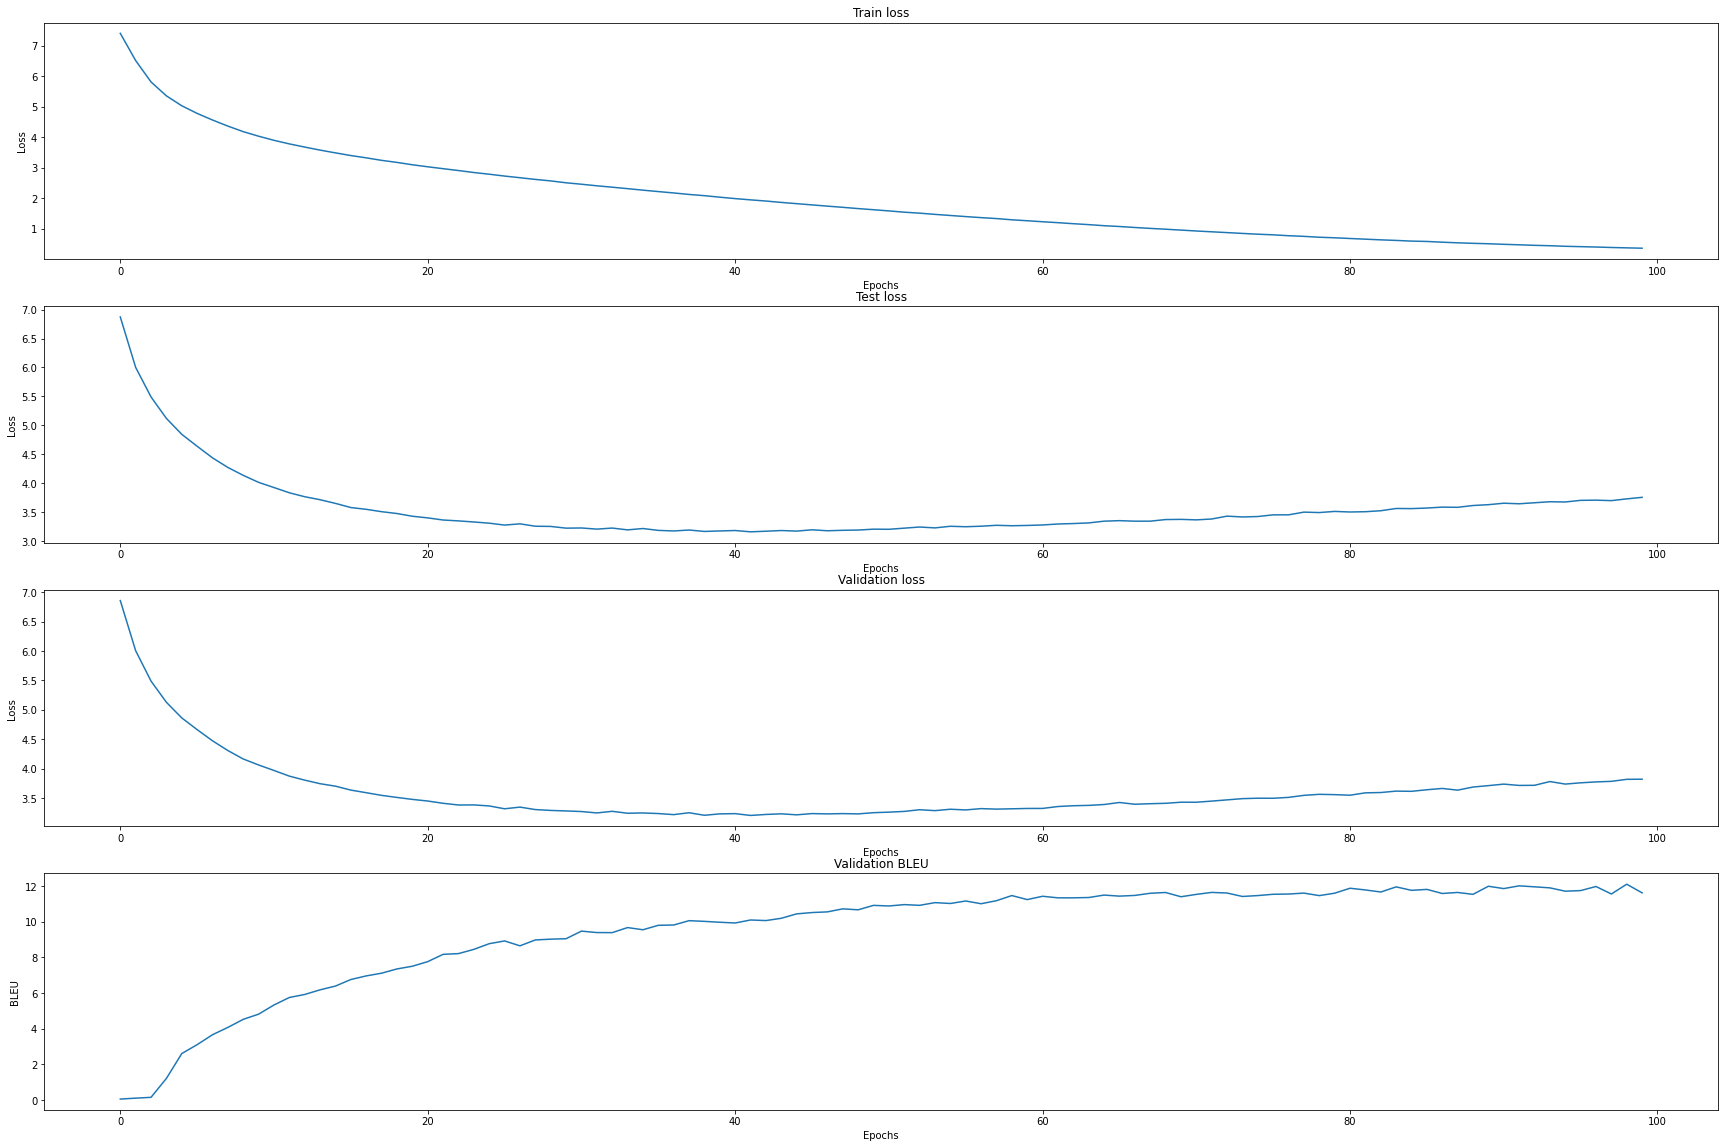

In [ ]:
plot_loss(train_loss_list, test_loss_list, valid_loss_list, valid_bleu_list)

In [ ]:
print(f"Max BLEU: {max(valid_bleu_list)}")

Max BLEU: 12.115900813575603


#Evaluate

In [ ]:
checkpoint = torch.load('drive/MyDrive/minGPT LV-EN/translator_model_best.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
with open('test_loss.txt', 'w') as f:
    f.write('\n'.join([str(s) for s in test_loss_list]))

with open('valid_loss.txt', 'w') as f:
    f.write('\n'.join([str(s) for s in valid_loss_list]))

with open('valid_blue.txt', 'w') as f:
    f.write('\n'.join([str(s) for s in valid_bleu_list]))

In [ ]:
from random import choice

for _ in range(5):
    idx = choice(range(len(valid_output)))

    context = valid_input[idx]
    encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
    x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10)[0]

    intent = len(encoded_input) + 1

    predicted = y[intent:]
    completion = tokenizer_output.decode(predicted, True)
    print(f'Input:            {context}')
    print(f'Predicted output: {completion}')
    print(f'Real output:      {valid_output[idx]}')
    print('--------------------------------------------------')

Input:            mēs var@@ am ap@@ me@@ sties augšā kal@@ nos &quot; .
Predicted output: we can go up the mountains there was a f@@ ar@@ m@@ ain road . &quot; it . &quot; l@@ an@@ ches . &quot; l@@ an@@ ches . &quot; . &quot; I said . &quot; . &quot; . &quot; no . &quot; . &quot; no . &quot; the f@@ ar@@ m@@ ess . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; l@@ ying . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; .
Real output:      we can find some place up in the mountains . &quot;
--------------------------------------------------
Input:            &quot; esmu nogur@@ is no ie@@ šanas &quot; .
Predicted output: I &apos;m tired to have a little tired . &quot; I &apos;m going to . &quot; . &quot; . &quot; it . &quot; . &quot; . &quot; she said . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; it . &quot; no . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot;

In [ ]:
idx = choice(range(len(valid_output)))

context = valid_input[idx]
encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
y, attention_state = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10, output_attention=True)

intent = len(encoded_input) + 1

predicted = y[0][intent:]
completion = tokenizer_output.decode(predicted,)
print(f'Input:            {context}')
print(f'Predicted output: {completion}')
print(f'Real output:      {valid_output[idx]}')
print('--------------------------------------------------')


Input:            &quot; not@@ eik@@ ti &quot; .
Predicted output: all right . &quot; right . &quot; I said . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . &quot; . . &quot; . &quot; . &quot; . &quot; . &quot; . . &quot; . &quot; . . &quot; . . . . . . &quot; . &quot; . . &quot; . &quot; . . . &quot; . . &quot; . . . . . . &quot; . . .
Real output:      &quot; sure . &quot;
--------------------------------------------------


AttributeError: ignored

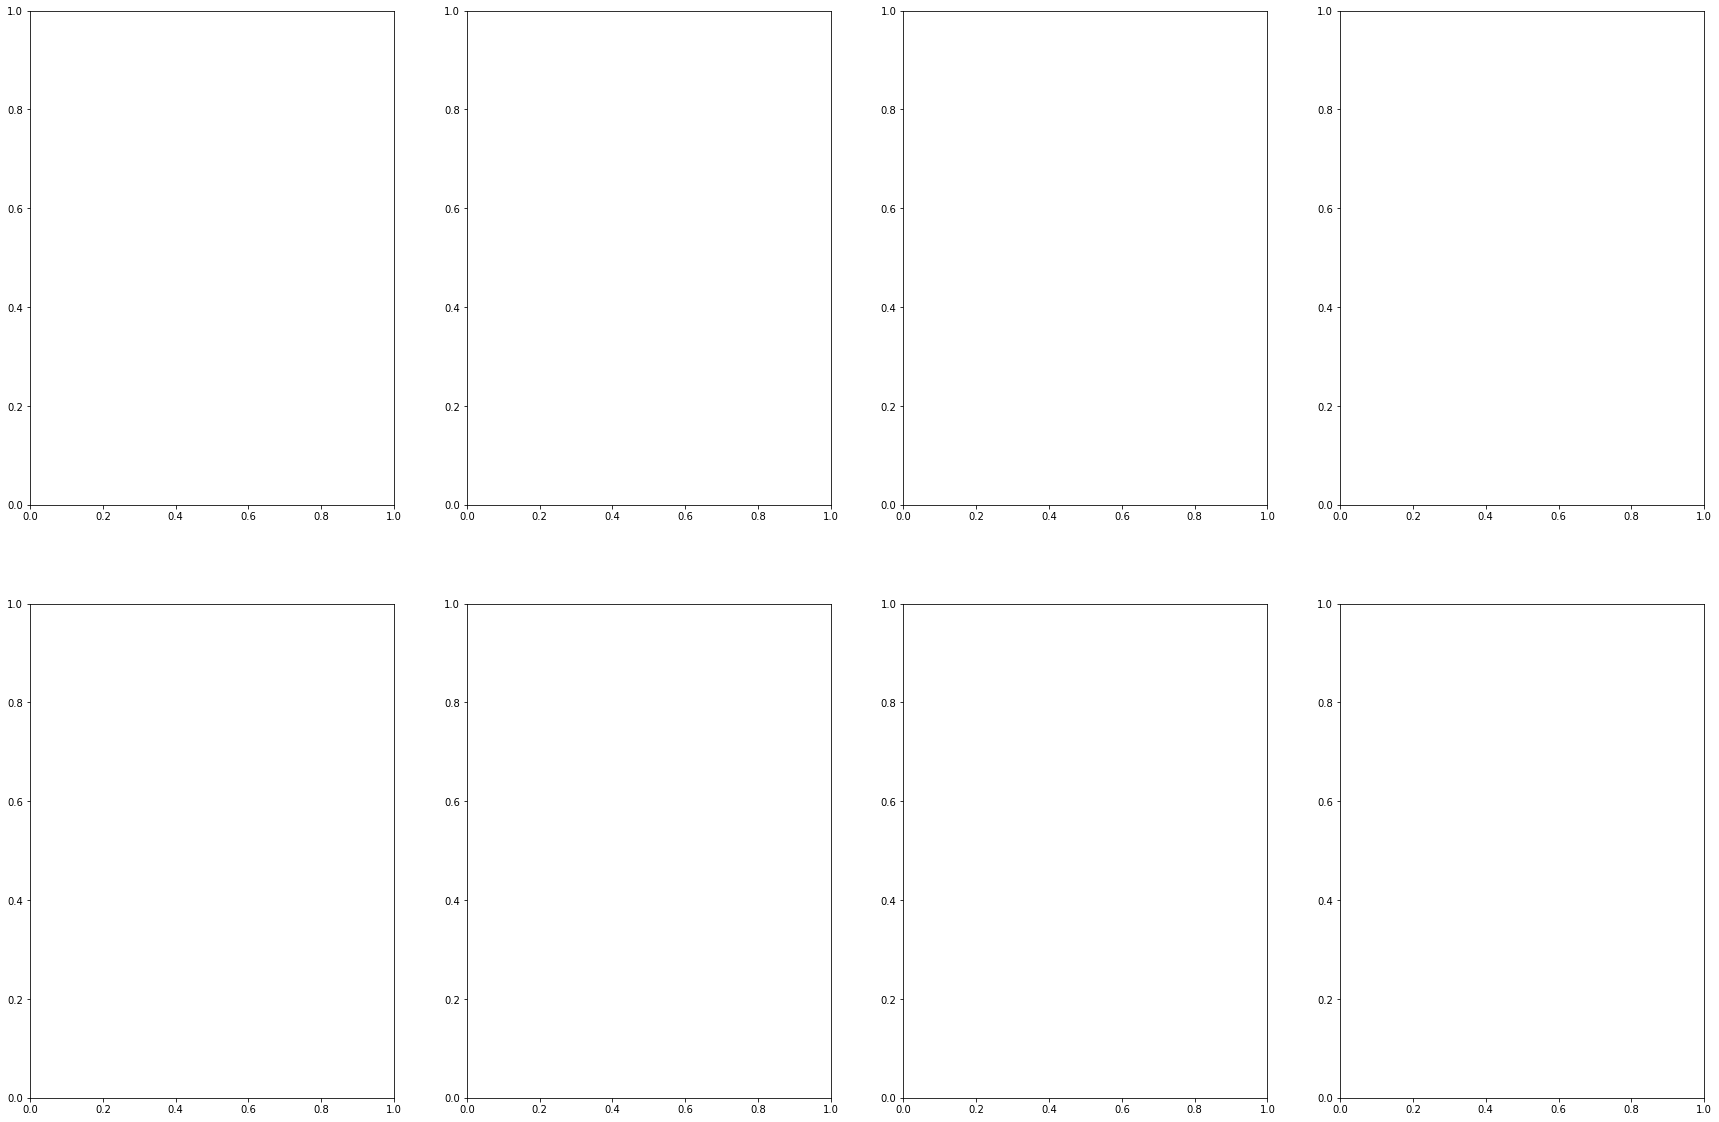

In [ ]:
fig, plots = plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))

axis_text = tokenizer_input.decode(encoded_input, True).split()

axis_text.append('<sep>')

axis_text += tokenizer_input.decode(predicted, True).split()

axis_text.append('<eos>')

limit = len(axis_text)
for bi in range(number_of_layers):
    for hi in range(number_of_heads):
        attetion_plot = torch.zeros(limit, limit)
        for di in range(limit):
            attetion_plot[:di, :di] = attention_state[bi][di][0,hi,:di,:di].data

        ax = plots[bi][hi]
        ax.matshow(attetion_plot.numpy(), cmap='bone')

        # Set up axes
        ax.set_xticklabels([''] + axis_text, rotation=90)
        ax.set_yticklabels([''] + axis_text)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Set up a title
        ax.set_title(f'Block {bi + 1} Head {hi + 1}', size=25, pad=30)
        
plt.show()

In [ ]:
# In case the previous cell is not plotting anything, uncomment the code below and execute. After that, the plotting should be fine.
# %matplotlib inline
# import numpy as np
# x = np.linspace(0, 10, 100)

# fig = plt.figure()
# plt.plot(x, np.sin(x), '-')
# plt.plot(x, np.cos(x), '--');

#Calculate BLEU

In [ ]:
def clean_tokens(sentence):
    return sentence.replace('@@ ', '').replace(' @', '').replace('@ ', '')

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# smooth = SmoothingFunction().method7

translation_results = []
eval_results = []
bleu_results = []
for idx, context in enumerate(valid_input):
    encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
    x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10)[0]

    intent = len(encoded_input) + 1
    predicted = y[intent:]
    completion = clean_tokens(tokenizer_output.decode(predicted, True))
    translation_results.append(completion)

    eval = clean_tokens(valid_output[idx])
    eval_results.append(eval)
    # bleu = sentence_bleu([eval], completion, smoothing_function=smooth)
    # bleu_results.append(bleu)

# print(f"Averare BLEU: {np.mean(bleu_results)}")

In [ ]:
with open('valid.txt', 'w') as f:
    f.write("\n".join(translation_results))

with open('eval.txt', 'w') as f:
    f.write("\n".join(eval_results))

In [ ]:
!perl mosesdecoder/scripts/generic/multi-bleu.perl eval.txt < valid.txt

In [ ]:
!cat valid.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > valid.detok.txt
!cat eval.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > eval.detok.txt

In [ ]:
!pip install sacrebleu

In [ ]:
import sacrebleu

with open('eval.detok.txt', 'r') as f:
    eval_results = [l.strip() for l in f.readlines()]
with open('valid.detok.txt', 'r') as f:
    translation_results = [l.strip() for l in f.readlines()]

refs = [eval_results]
sys = translation_results
bleu = sacrebleu.corpus_bleu(sys, refs)
print(bleu.score)

#Interactive translator

In [ ]:
context = input("Enter your English text to translate: ")

# Predict Latvian output
encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
y, attention_state = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10, output_attention=True)

intent = len(encoded_input) + 1

predicted = y[0][intent:]
completion = tokenizer_output.decode(predicted, True)
print(f'Input:            {context}')
print(f'Predicted output: {completion}')


# Plot attention
fig, plots = plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))

axis_text = tokenizer_input.decode(encoded_input, True).split()

axis_text.append('<sep>')

axis_text += tokenizer_input.decode(predicted, True).split()

axis_text.append('<eos>')

limit = len(axis_text)
for bi in range(number_of_layers):
    for hi in range(number_of_heads):
        attetion_plot = torch.zeros(limit, limit)
        for di in range(limit):
            attetion_plot[:di, :di] = attention_state[bi][di][0,hi,:di,:di].data

        ax = plots[bi][hi]
        ax.matshow(attetion_plot.numpy(), cmap='bone')

        # Set up axes
        ax.set_xticklabels([''] + axis_text, rotation=90)
        ax.set_yticklabels([''] + axis_text)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Set up a title
        ax.set_title(f'Block {bi + 1} Head {hi + 1}', size=25, pad=30)
        
plt.show()